In [240]:
import sys
import os

import pandas as pd
import duckdb

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..')
sys.path.append(PROJECT_SRC_PATH)

import pickle
import transit_access.utils as utils

In [239]:
%load_ext autoreload
%autoreload 2

In [2]:
import duckdb
db = duckdb.connect()
db.execute("INSTALL spatial")
db.execute("INSTALL httpfs")

In [227]:
SQL = """
    SELECT
        *
    FROM
        read_parquet('../../predictive-modeling/data/overture/places/type=place/*', filename=true, hive_partitioning=1)
     WHERE
        bbox.minx > 12.265517
        and bbox.maxx < 12.494043
        and bbox.miny > 51.264676
        and bbox.maxy < 51.396814
"""
        # Berlin
        # bbox.minx > 13.003693
        # and bbox.maxx < 13.796082
        # and bbox.miny > 52.361345
        # and bbox.maxy < 52.674717

        # Bogota
        # bbox.minx > -74.349936
        # and bbox.maxx < -73.861731
        # and bbox.miny > 4.416440
        # and bbox.maxy < 4.900977

places_df = db.query(SQL).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [230]:
from shapely.geometry import Point
import geopandas as gpd


places_df['main_category'] = places_df['categories'].apply(lambda x: x['main'])
geom = places_df['bbox'].apply(lambda x: Point(x['minx'], x['miny']))
places_df = places_df[['id', 'main_category', 'confidence']]
poi_gdf = gpd.GeoDataFrame(places_df, geometry=geom, crs="EPSG:4326")
poi_gdf = poi_gdf.to_crs('EPSG:3035')
# poi_gdf = poi_gdf.to_crs('EPSG:21897')

poi_gdf.sample(frac=0.01).explore()


In [39]:
from shapely import wkb
import json
# import geojson
# places_df['categories'].apply(lambda x: x['main']).value_counts(dropna=False).head(20)
# geojson.Polygon(places_df['geometry'].iloc[1])
# places_df['geometry'].iloc[10]
# wkb.loads(places_df['geometry'].iloc[1])


import json
# places_df['categories'].apply(lambda x: x['main']).value_counts(dropna=False).head(20)
# places_df#['geometry']

# hmb["places"].convert("bbox", lambda v: {
#     "longitude": json.loads(v)["minx"],
#     "latitude": json.loads(v)["miny"]
# }, multi=True)

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_79550/1444980416.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-

In [232]:


with open('../data-xml/transit-network-connectivity-bogota.pkl', 'rb') as f:
    G_bog = pickle.load(f)

with open('../results-eu/transit-network-connectivity-Leipzig-20230824-03-48-39.pkl', 'rb') as f:
    G_lei = pickle.load(f)


In [ ]:
scores = {}
files = glob.glob('../results-xml/access-score-*.gpkg')

for f in files:
    city = f.split('-')[3]
    scores[city] = gpd.read_file(f)


In [282]:
# import networkx as nx
# import numpy as np
# import functools

# stops = utils.nodes_to_gdf(G_lei)

# # # TODO: maybe not assign POI only to nearest station, but to all stations within 600m with respective weight (e.g. depending on distance and n_departures at station)
# poi_w_stop = gpd.sjoin_nearest(poi_gdf, stops[['geometry']].to_crs(poi_gdf.crs), how='left', distance_col='distance', max_distance=600)
# # # poi_w_stop[poi_w_stop['distance'] < 1000]['distance'].hist(bins=100)
# stops['n_POI'] = poi_w_stop.value_counts('index_right')
# # # stops.explore('n_POI')

# stops_sample = stops.to_crs(3035)#.sample(frac=0.1)

# dm = stops_sample.geometry.apply(lambda g: stops_sample.geometry.distance(g)) / 1000

def euclidean_speed(source, G, dis_matrix):
    time = nx.single_source_dijkstra_path_length(G, source=source.name, weight='weight')
    time = pd.Series(time) + min(source['headaway'] / 2, 3600) # upper bound for waiting time
    time = time[time.index.isin(dis_matrix.index)] # not all stops may be reachable and thus not included in shorted path times
    # return time
    # time = time.loc[dis_matrix.index] # only needed if subset of stops is used
    euc_speed = dis_matrix.loc[source.name] / (time / 60 / 60) # km/h
    return euc_speed

def mean_euclidean_speed(source, G, dis_matrix):
    return euclidean_speed(source, G, dis_matrix).mean()


def weighted_mean_euclidean_speed(source, weights, G, dis_matrix):
    euc_speed = euclidean_speed(source, G, dis_matrix)
    euc_speed = euc_speed.dropna()
    weights = weights.loc[euc_speed.index]
    weighted_euc_speed = np.average(euc_speed.sort_index(), weights=weights)
    return weighted_euc_speed

# euc_speed = stops.head(200).index.map(euc_speed_func)
# stops['euc_speed'] = stops.index.to_series().apply(euc_speed_func)

stops_sample = stops_sample.sort_index()

# euc_speed_func = functools.partial(euclidean_speed, G=G_lei, dis_matrix=dm)
# df = stops_sample.apply(euc_speed_func, axis=1)
# # fill NaNs because some stops have no nearby POI
# stops_sample['weighted_euc_speed'] = np.average(df.sort_index(axis=1), weights=stops_sample['n_POI'].fillna(0), axis=1)

# fill NaNs because some stops have no nearby POI
# euc_speed_func = functools.partial(weighted_mean_euclidean_speed, weights=stops_sample['n_POI'].fillna(0), G=G_lei, dis_matrix=dm)
# stops_sample['weighted_euc_speed_2'] = stops_sample.apply(euc_speed_func, axis=1)

euc_speed_func = functools.partial(mean_euclidean_speed, G=G_lei, dis_matrix=dm)
stops_sample['euc_speed'] = stops_sample.apply(euc_speed_func, axis=1)

# euc_speed.hist(bins=100)
# stops['euc_speed'] = euc_speed
# stops.loc[['T_11236_STOP-T_2240']].explore()
stops_sample
# G_bog.nodes['T_11236_STOP-T_2240']

,y,x,headaway,service_frequency,route_id,route_type,route_short_name,centrality,weighted_euc_speed,geometry,n_POI,weighted_euc_speed_2,euc_speed
000000145@@LVBUS_N6,3.141818e+06,4.491370e+06,4260.000000,0.125000,LVBUS_N6,3,N6,0.000410,NaN,POINT (4491369.572 3141818.289),34.0,4.999698,5.177407
000000145@@LVTRAM1,3.141818e+06,4.491370e+06,9253.333333,0.416667,LVTRAM1,0,1,0.000411,NaN,POINT (4491369.572 3141818.289),34.0,3.205496,3.955601
000000145@@LVTRAM10,3.141818e+06,4.491370e+06,7600.000000,0.166667,LVTRAM10,0,10,0.000408,NaN,POINT (4491369.572 3141818.289),34.0,3.641165,3.938952
000000145@@LVTRAM14,3.141818e+06,4.491370e+06,19860.000000,0.208333,LVTRAM14,0,14,0.000414,NaN,POINT (4491369.572 3141818.289),34.0,1.791704,3.966814
000000145@@LVTRAM3,3.141818e+06,4.491370e+06,404.657534,9.125000,LVTRAM3,0,3,0.000402,NaN,POINT (4491369.572 3141818.289),34.0,9.672888,9.117749
...,...,...,...,...,...,...,...,...,...,...,...,...,...
008098205@@800486S4,3.139903e+06,4.486823e+06,1142.400000,3.166667,800486S4,109,S4,0.000515,NaN,POINT (4486822.587 3139902.834),33.0,4.514838,6.637175
008098205@@800486S5,3.139903e+06,4.486823e+06,2082.857143,1.791667,800486S5,109,S5,0.000512,NaN,POINT (4486822.587 3139902.834),33.0,3.601417,5.535999
008098205@@800486S5X,3.139903e+06,4.486823e+06,1890.000000,1.625000,800486S5X,109,S5X,0.000512,NaN,POINT (4486822.587 3139902.834),33.0,3.751405,5.718499
008098205@@800486S6,3.139903e+06,4.486823e+06,1120.273973,3.083333,800486S6,109,S6,0.000511,NaN,POINT (4486822.587 3139902.834),33.0,4.556227,6.614026


In [218]:
# stops_sample.to_pickle('../data-xml/Berlin-stops-sample10-w-weighted-speed-to-POIs.pkl')

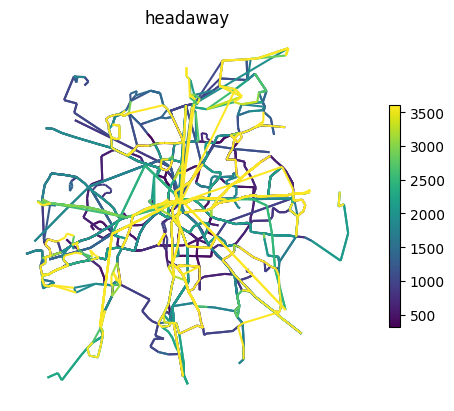

In [271]:
utils.plot_edges(G_lei, 'headaway', adjust_linewith=False)

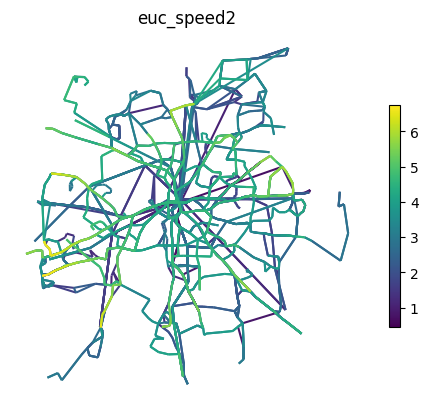

In [274]:
nx.set_node_attributes(G_lei, stops_sample['euc_speed'].replace(np.inf,np.nan).to_dict(), 'euc_speed2')
utils.plot_edges(G_lei, 'euc_speed2', adjust_linewith=False)

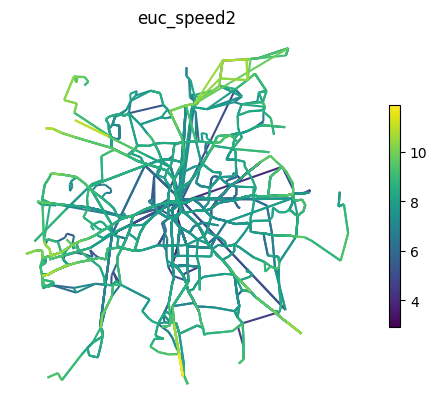

In [270]:
nx.set_node_attributes(G_lei, stops_sample['euc_speed'].replace(np.inf,np.nan).to_dict(), 'euc_speed2')
utils.plot_edges(G_lei, 'euc_speed2', adjust_linewith=False)

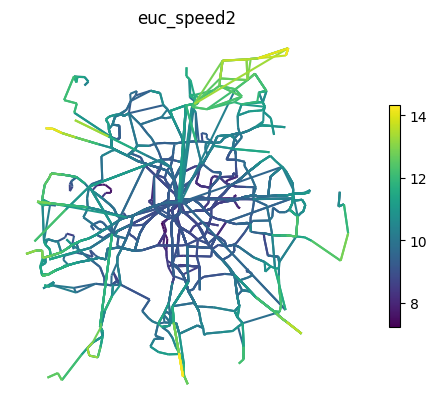

In [264]:
nx.set_node_attributes(G_lei, stops_sample['euc_speed'].replace(np.inf,np.nan).to_dict(), 'euc_speed2')
utils.plot_edges(G_lei, 'euc_speed2', adjust_linewith=False)

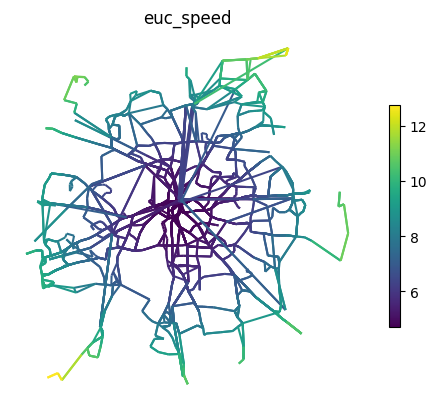

In [254]:
nx.set_node_attributes(G_lei, stops_sample['euc_speed'].to_dict(), 'euc_speed')
utils.plot_edges(G_lei, 'euc_speed', adjust_linewith=False)

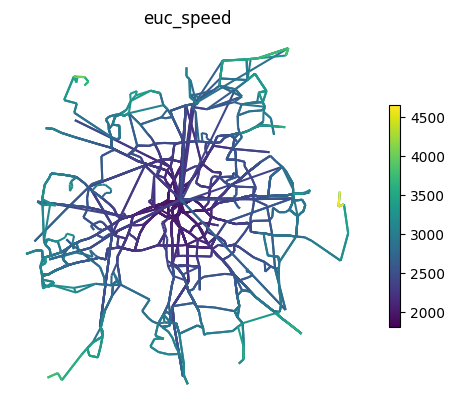

In [252]:
nx.set_node_attributes(G_lei, stops_sample['euc_speed'].to_dict(), 'euc_speed')
utils.plot_edges(G_lei, 'euc_speed', adjust_linewith=False)

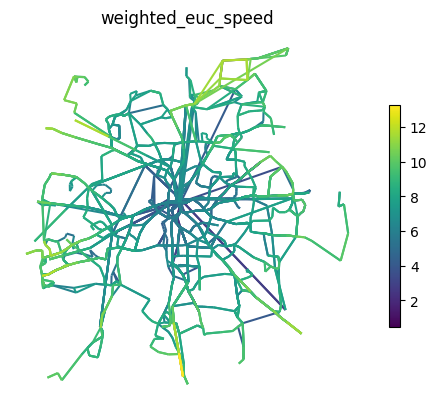

In [244]:
# stops_sample.dropna(subset='weighted_euc_speed_2').explore(column='weighted_euc_speed_2', legend=True)

nx.set_node_attributes(G_lei, stops_sample['euc_speed'].to_dict(), 'euc_speed')
utils.plot_edges(G_lei, 'euc_speed', adjust_linewith=False)
# stops_sample.groupby('route_type')['weighted_euc_speed_2'].hist(bins=30, density=True, legend=True)


In [205]:
# dm.index
# time = pd.Series(nx.single_source_dijkstra_path_length(G_ber, source=stops_sample.iloc[0].name, weight='weight'))
# time.loc[dm.index] # only needed if subset of stops is used



time[time.index.isin(dm.index)]


000300004001-17514_400                 0.000000
de:11000:900100020::3-17350_700      441.602515
de:11000:900100020::1-17453_700      467.151645
de:11000:900100010::3-17457_700      518.755223
de:11000:900100010::5-21284_700      620.481883
                                       ...     
de:11000:900092255::1-17476_700     9236.978135
de:11000:900096307::3-17491_700     9290.211437
de:11000:900195502::1-17494_700    10152.680621
de:11000:900049201::1-21680_700    12674.995865
de:11000:900049156::2-21680_700    13575.184754
Length: 1449, dtype: float64

In [213]:
weighted_mean_euclidean_speed(stops_sample.iloc[0], weights=stops_sample['n_POI'].fillna(0), G=G_ber, dis_matrix=dm)
# euclidean_speed(stops_sample.iloc[0], G=G_ber, dis_matrix=dm)

7.68229323026163

In [100]:

with open('../data-xml/transit-network-connectivity-berlin.pkl', 'rb') as f:
    G_ber = pickle.load(f)


In [101]:
stops_bog = stops.copy()

<AxesSubplot: >

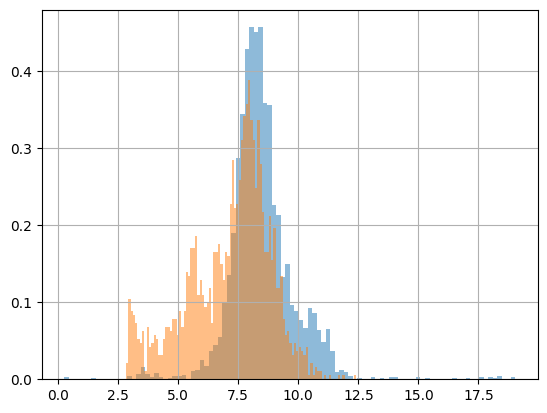

In [284]:
stops_bog['euc_speed'].hist(bins=100, density=True, alpha=0.5)
stops_sample['euc_speed'].hist(bins=100, density=True, alpha=0.5)